In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist

In [2]:
# 计算夹角
def clockwise_angle(v1, v2):
    x1,y1 = v1
    x2,y2 = v2
    dot = x1*x2+y1*y2
    det = x1*y2-y1*x2
    theta = np.arctan2(det, dot)
    theta = theta if theta>0 else 2*np.pi+theta
    return theta*180/np.pi

In [3]:
# 计算环状情绪每个分区的点数
def area_count(data):
    count = np.zeros((3,12))
    angles = [x*30 for x in range(12)]
    for i in range(data.shape[0]):
        if type(data.loc[i, '效价']) in [float, np.float64] and type(data.loc[i, '唤醒']) in [float, np.float64]:
            x = data.loc[i, '效价']
            y = data.loc[i, '唤醒']*2-1
            if x*x+y*y<1/9:
                area1=0
            else:
                if x*x+y*y<4/9:
                    area1=1
                else:
                    area1=2
            angle = clockwise_angle([1,0], [x,y])
            for i in range(len(angles)):
                if angle>angles[i]:
                    area2=i
            count[area1, area2] += 1
    count = count/count.sum()
    return count

In [4]:
# 色谱截断
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

In [5]:
# 画环状情绪图
def draw_Circumplex_Model(x, path):
    x_stand = (x-x.min())/(x.max()-x.min())
    fig = plt.figure(figsize=(10,8))
    ax = axisartist.Subplot(fig, 1,1,1)
    # 字体
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    # 颜色
    mycolors = truncate_colormap(plt.get_cmap('cubehelix_r'), 0.05, 0.4)
    colors0 = [mycolors(sign) if sign>0 else '#F5F5F5' for sign in x_stand[0]]
    colors1 = [mycolors(sign) if sign>0 else '#F5F5F5' for sign in x_stand[1]]
    colors2 = [mycolors(sign) if sign>0 else '#F5F5F5' for sign in x_stand[2]]
    # 画图
    plt.pie([1 for _ in range(12)], radius=0.9, wedgeprops=dict(width=0.3,edgecolor='w'), colors=colors0)
    plt.pie([1 for _ in range(12)], radius=0.6, wedgeprops=dict(width=0.3,edgecolor='w'), colors=colors1)
    plt.pie([1 for _ in range(12)], radius=0.3, wedgeprops=dict(width=0.3,edgecolor='w'), colors=colors2)
    
    # 标题
    plt.title("Circumplex Model\n" + re.findall(r'有用部分数据/(.*?)_情绪环状图', path)[-1], fontdict={'fontsize':20})
    # 文本框
    plt.text(-1.45, -0.02, 'Unpleasant', fontdict={'fontsize':16})
    plt.text(0.95, -0.02, 'Pleasant', fontdict={'fontsize':16})
    plt.text(-0.13, 0.95, 'Active', fontdict={'fontsize':16})
    plt.text(-0.17, -1, 'Inactive', fontdict={'fontsize':16})
    # 色谱
    mappable=ax.scatter(x, x, c=x, cmap=mycolors)
    cbar=plt.colorbar(mappable)
    cbar.set_ticks([0, x.max()/4, x.max()/2, x.max()*3/4, x.max()])
    cbar.set_ticklabels(['{:.0f}%'.format(x) for x in [0, x.max()*100/4, x.max()*100/2, x.max()*100*3/4 ,x.max()*100]])
    pos = ax.get_position()
    cbar.ax.set_position([pos.x0 + pos.width + 0.1, pos.y0 + pos.height*0.1, 0.2, pos.height*0.8])
    # 保存
    plt.savefig(path)

In [6]:
# 画情绪时序和情绪占比
def draw_series_pie(data, path):
    # 数据清洗
    data_clean = data[[type(x) is not str for x in data['愉快']]].copy()
    # 设置画布
    fig = plt.figure(figsize=(25, 5))
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[4, 1])
    # 颜色
    em_list = ['愉快', '悲伤', '愤怒', '惊奇', '惧怕']
    mycolors = ['#FFE5B4', '#87CEEB', '#E32636', '#7FFFD4', '#E680FF']
    # 情绪时序图
    ax1 = fig.add_subplot(gs[0,0])
    for i,em in enumerate(['愉快', '悲伤', '愤怒', '惊奇', '惧怕']):
        ax1.plot(data_clean['视频时间'], data_clean[em], label = em, color=mycolors[i])
    #修改x轴的密度
    tick_spacing = int(data_clean.shape[0]/6)
    ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))
    ax1.legend()
    ax1.set_title("情绪时序\n" + re.findall(r'有用部分数据/(.*?)_情绪时序与占比图', path)[-1], fontdict={'fontsize':12})
    # 情绪处理
    em_sum = []
    for em in em_list:
        em_threshold = data_clean[em].astype(float).describe()['25%']
        data_clean[em] = data_clean[em].astype(float).apply(lambda x: x if x>em_threshold else 0)
        em_sum.append(data_clean[em].sum())
    # 饼图
    ax2 = fig.add_subplot(gs[0,1])
    ax2.pie(em_sum, labels=em_list, colors=mycolors)
    ax2.set_title("情绪占比\n" + re.findall(r'有用部分数据/(.*?)_情绪时序与占比图', path)[-1], fontdict={'fontsize':20})
    # 保存
    fig.savefig(path)

## 自我介绍

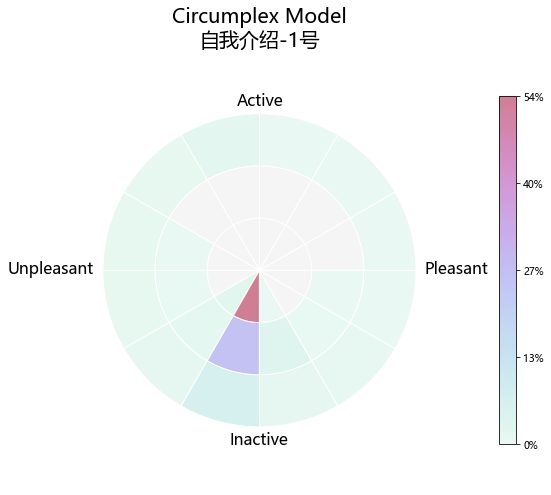

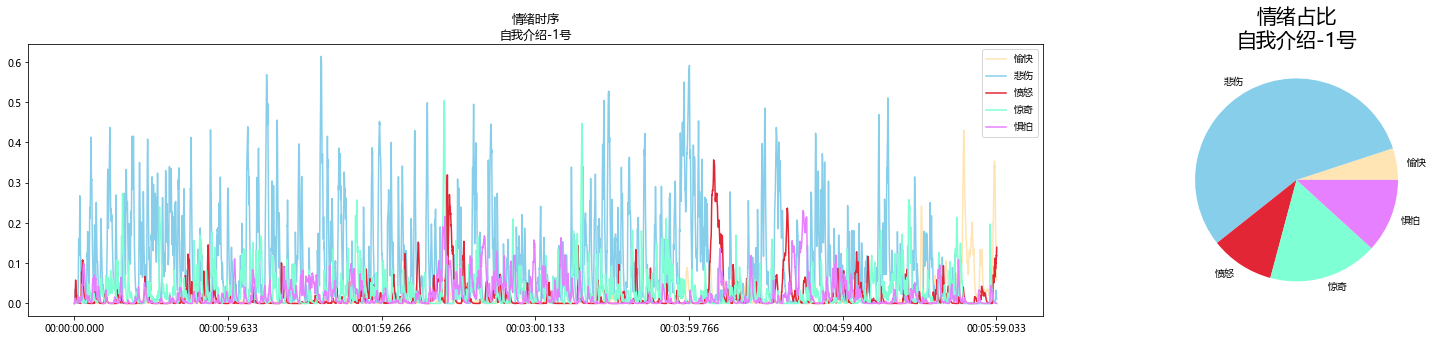

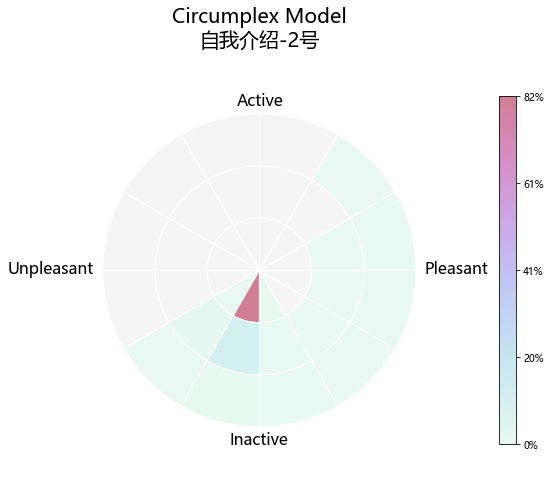

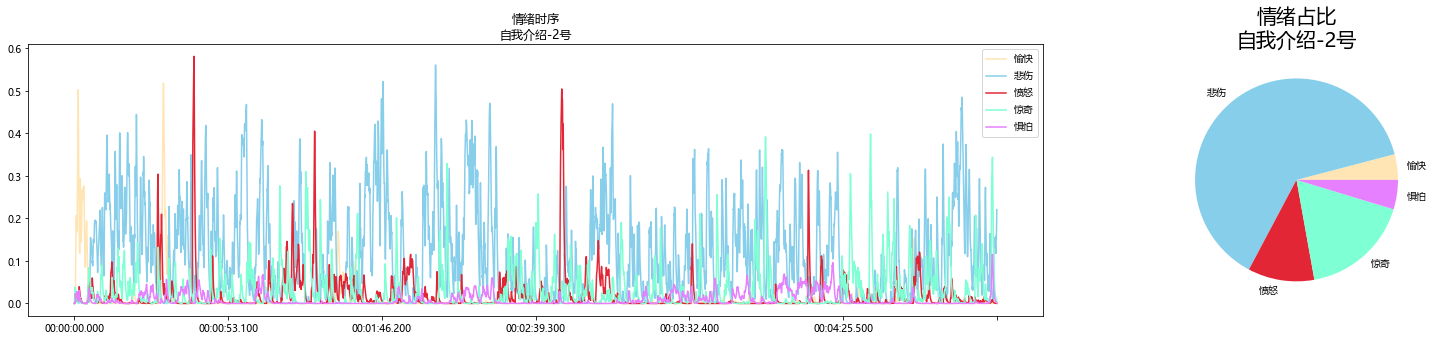

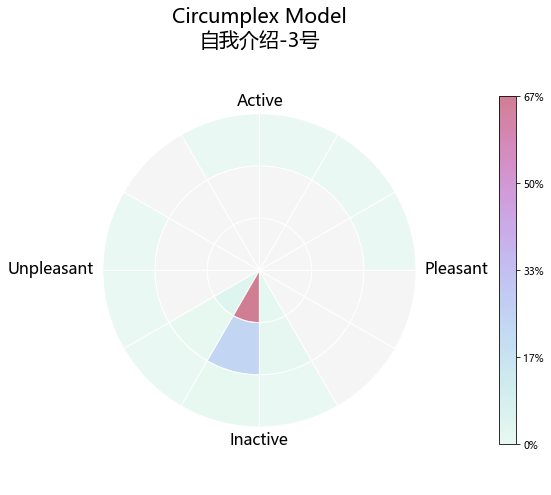

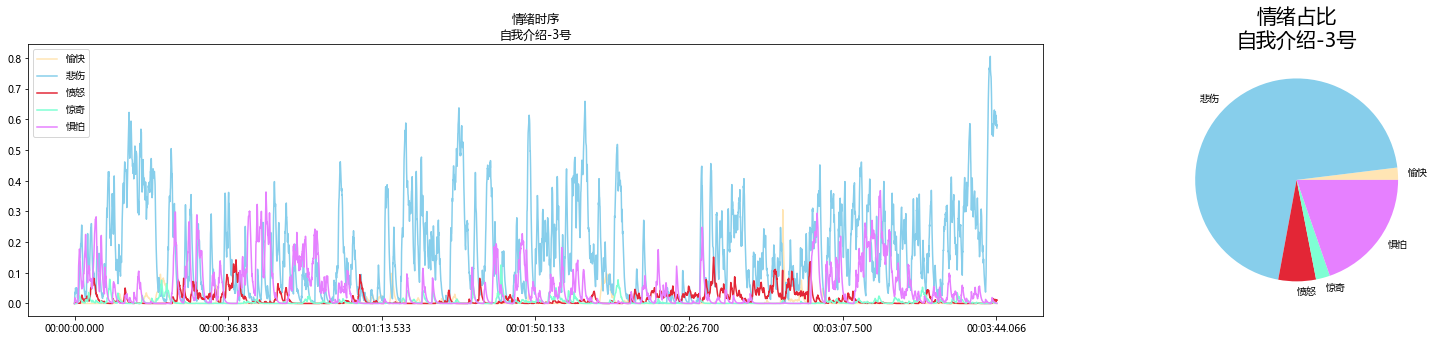

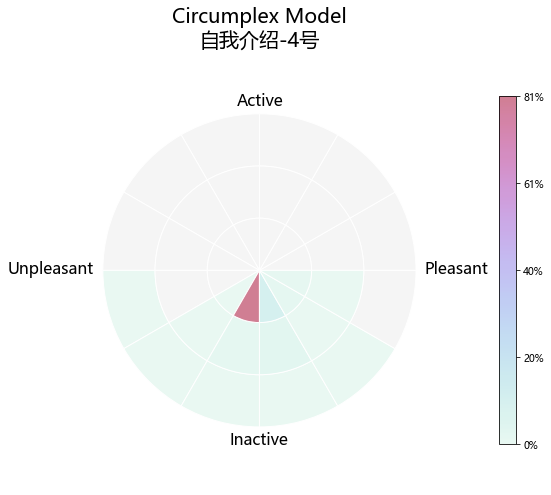

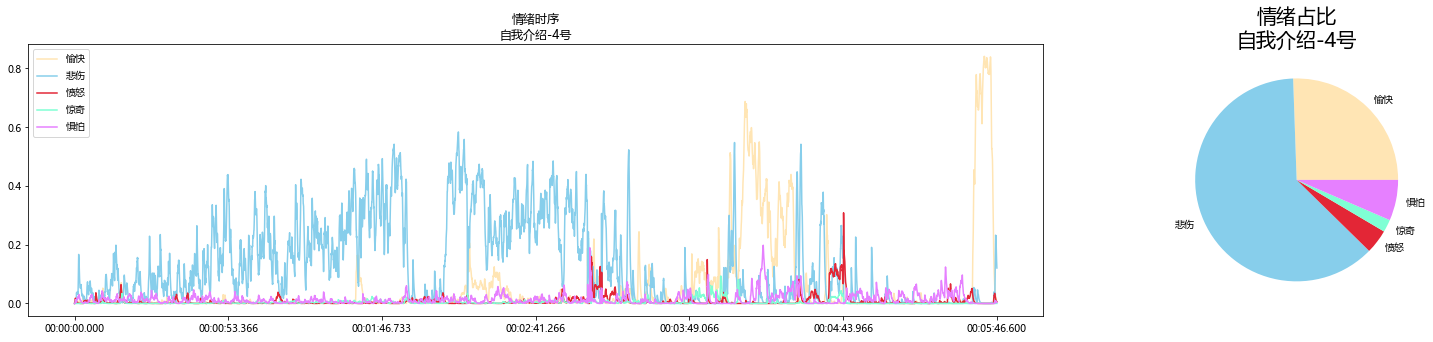

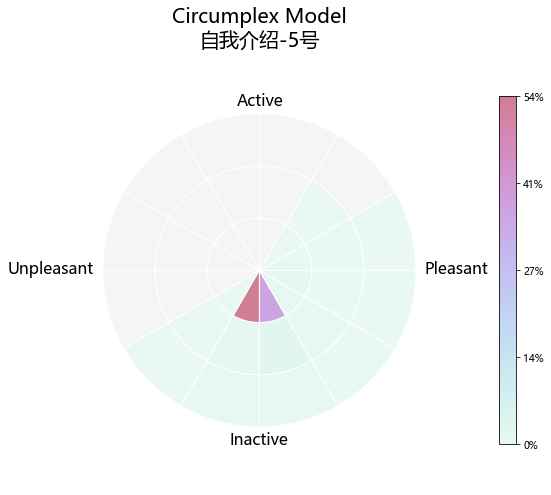

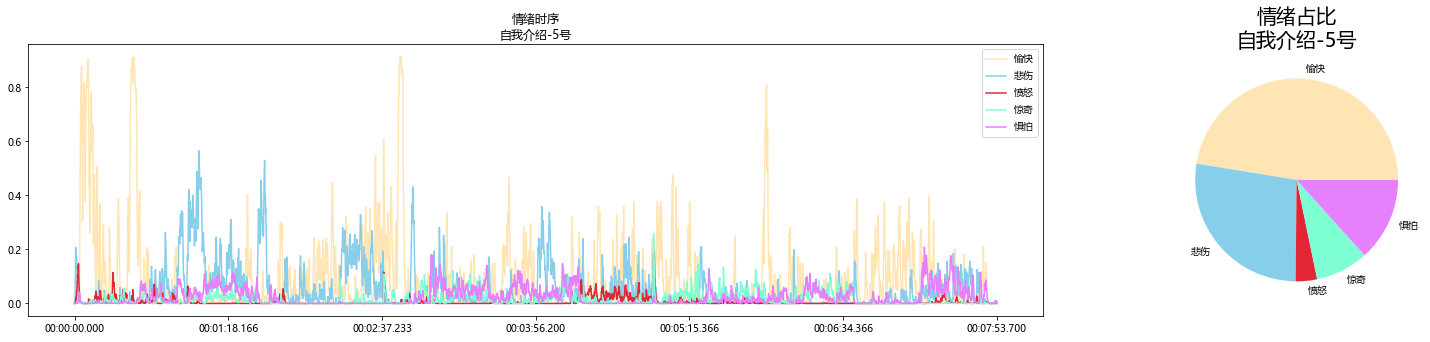

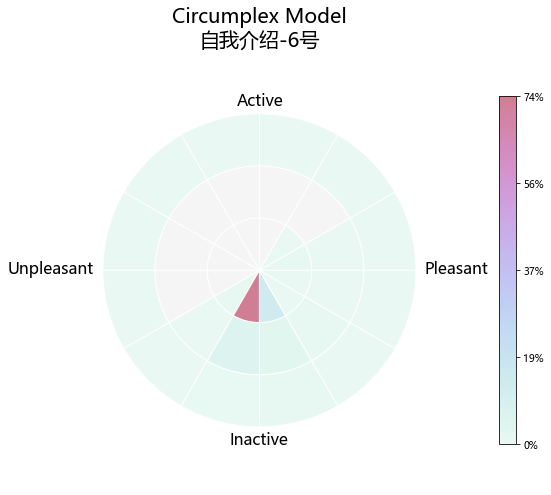

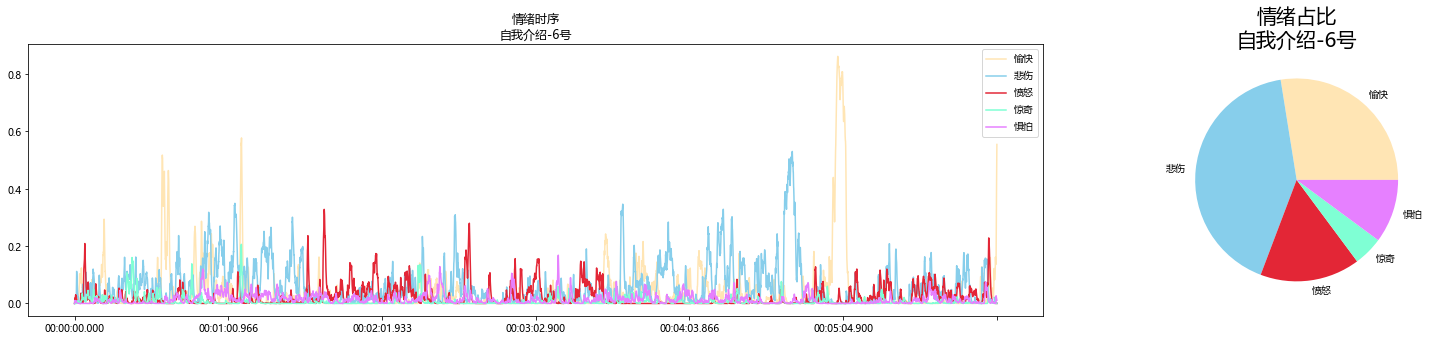

In [7]:
for i in range(6):
    data = pd.read_excel(f'C:/Users/25529/Desktop/File/2023spring/语言风格分析/4.24测试分析数据/面部情绪/有用部分数据/自我介绍-{i+1}号.xlsx', header=12)
    x = area_count(data)
    draw_Circumplex_Model(x, f'C:/Users/25529/Desktop/File/2023spring/语言风格分析/4.24测试分析数据/面部情绪/有用部分数据/自我介绍-{i+1}号_情绪环状图.png')
    draw_series_pie(data, f'C:/Users/25529/Desktop/File/2023spring/语言风格分析/4.24测试分析数据/面部情绪/有用部分数据/自我介绍-{i+1}号_情绪时序与占比图.png')

## 偷企鹅蛋

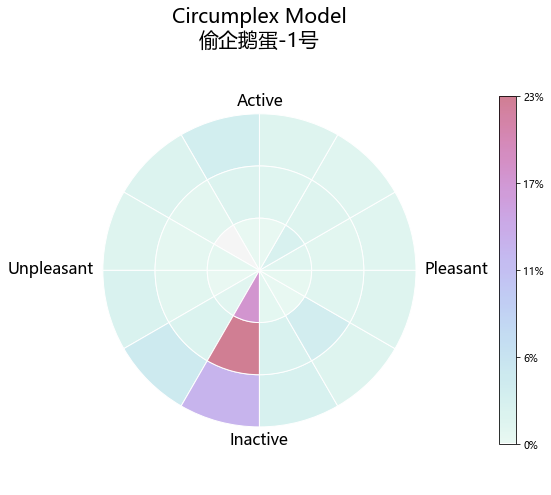

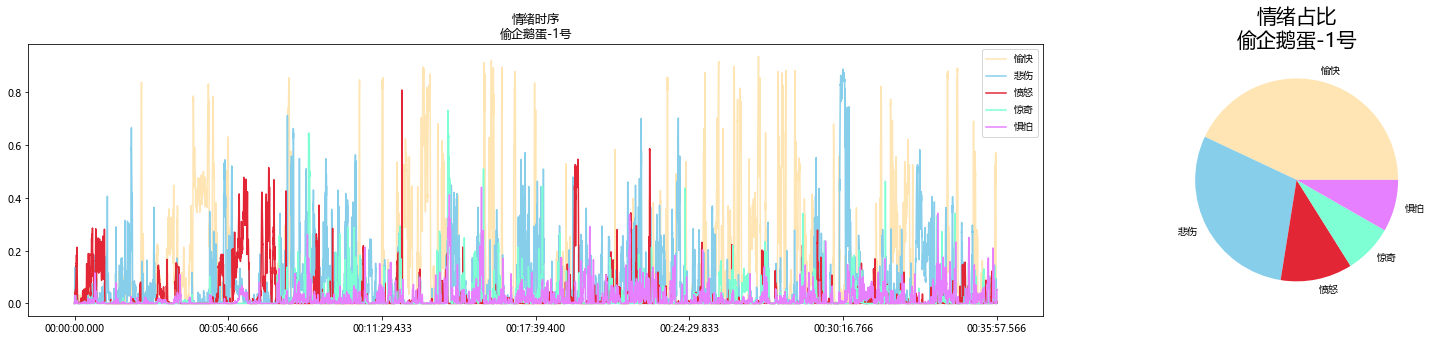

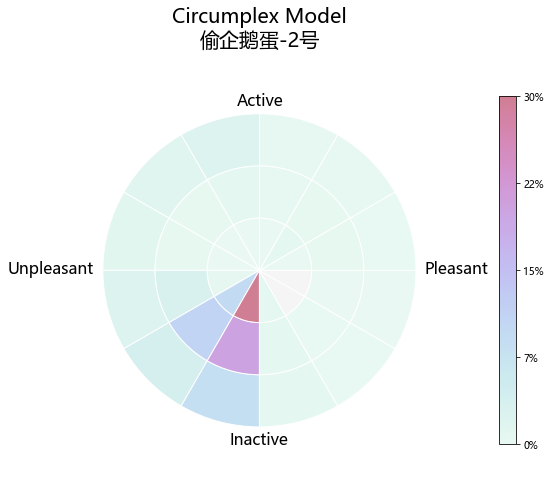

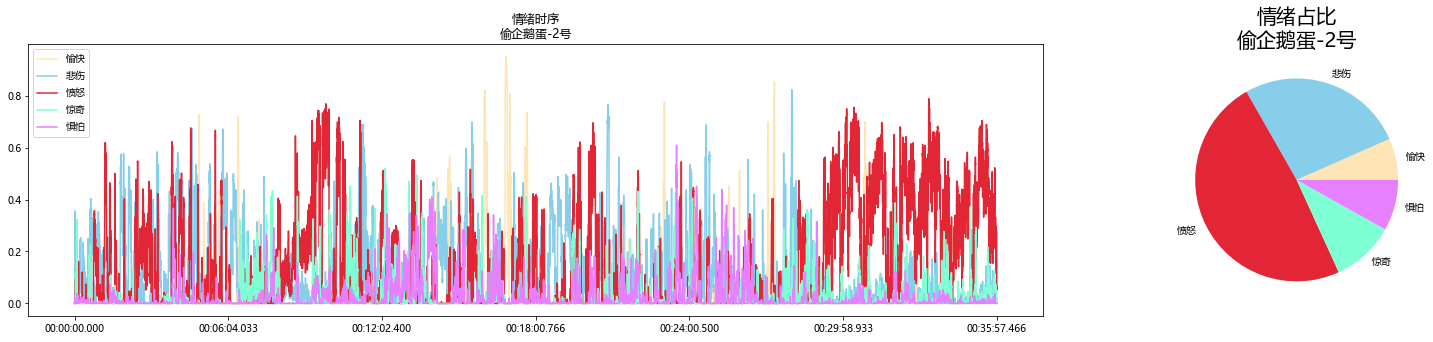

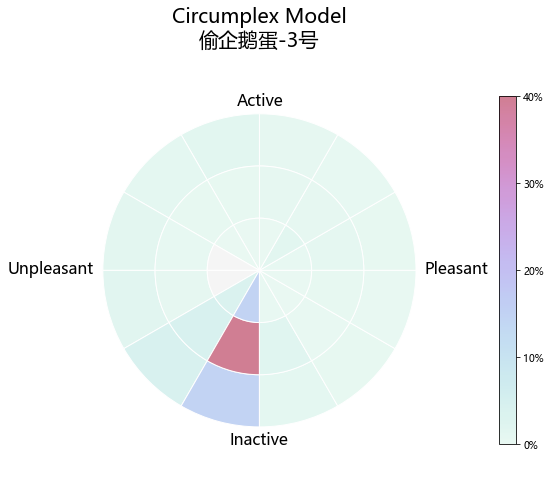

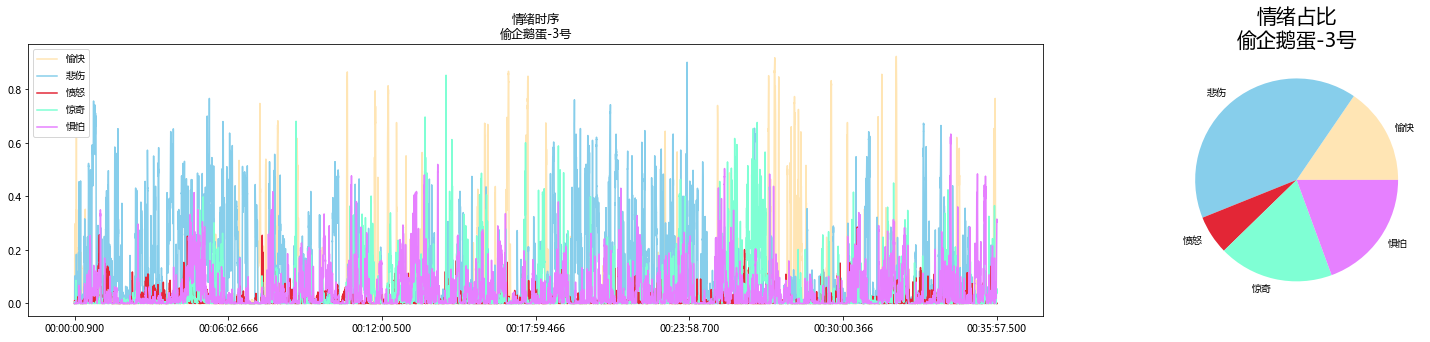

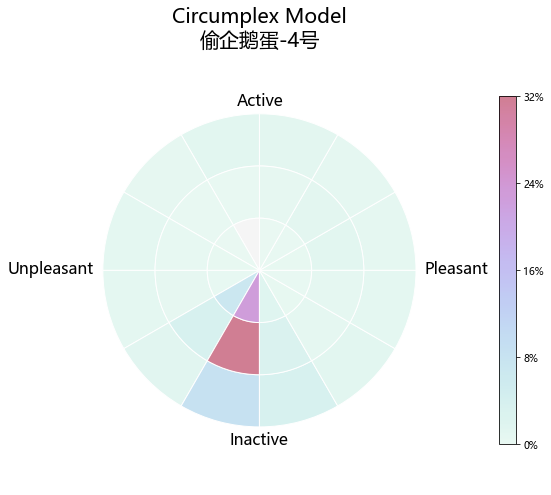

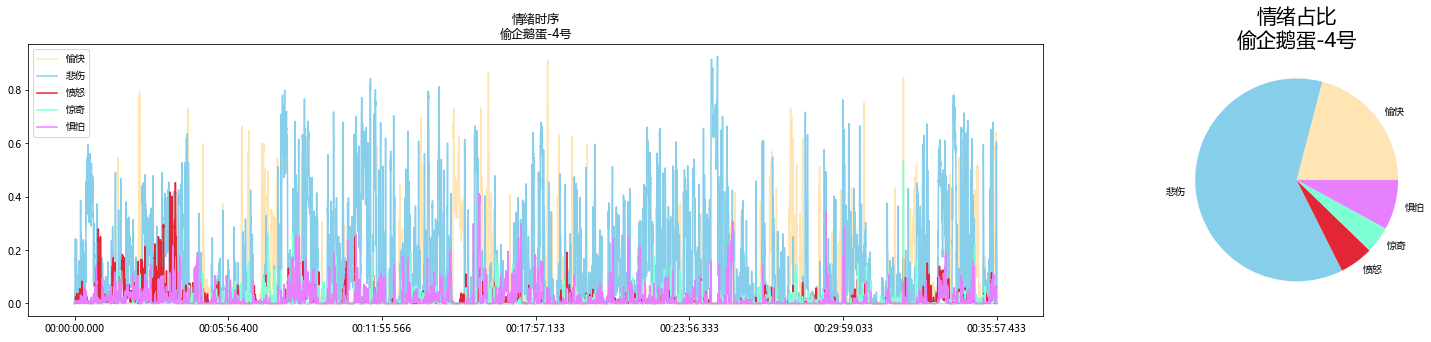

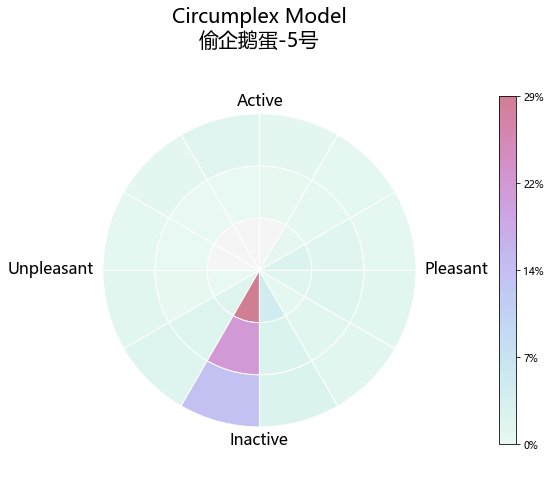

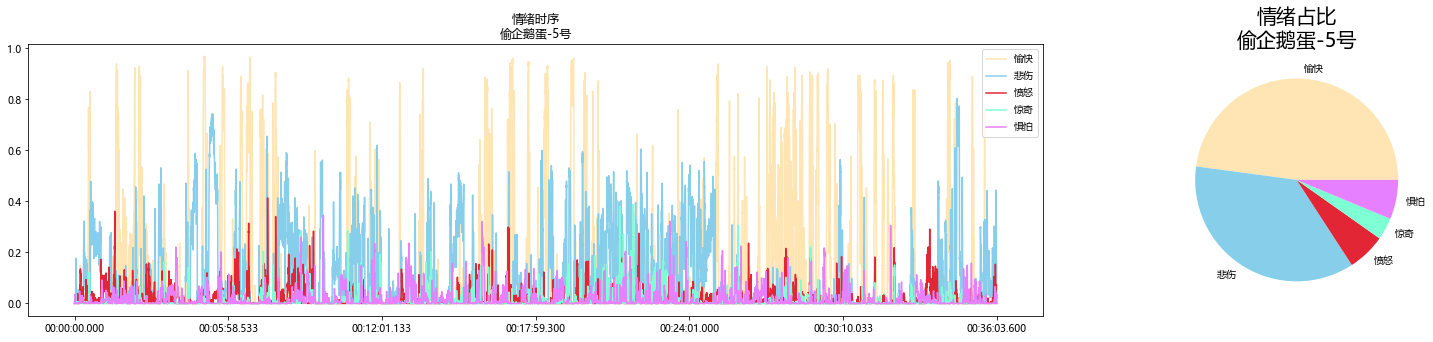

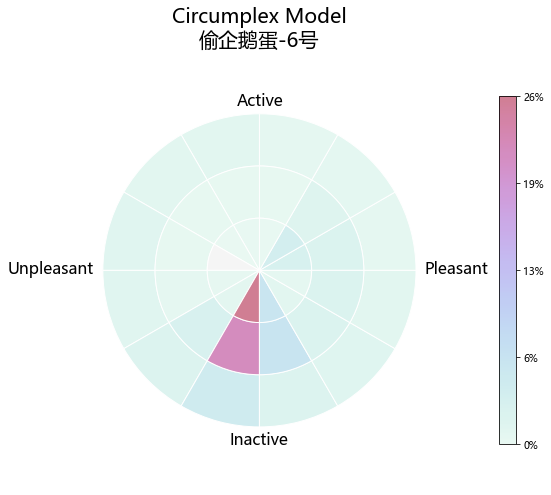

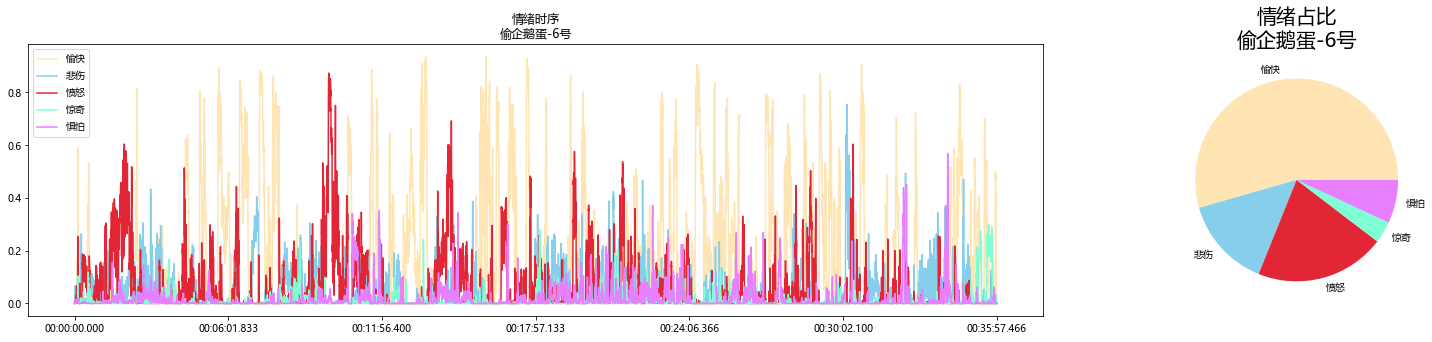

In [8]:
for i in range(6):
    data = pd.read_excel(f'C:/Users/25529/Desktop/File/2023spring/语言风格分析/4.24测试分析数据/面部情绪/有用部分数据/偷企鹅蛋-{i+1}号.xlsx', header=12)
    x = area_count(data)
    draw_Circumplex_Model(x, f'C:/Users/25529/Desktop/File/2023spring/语言风格分析/4.24测试分析数据/面部情绪/有用部分数据/偷企鹅蛋-{i+1}号_情绪环状图.png')
    draw_series_pie(data, f'C:/Users/25529/Desktop/File/2023spring/语言风格分析/4.24测试分析数据/面部情绪/有用部分数据/偷企鹅蛋-{i+1}号_情绪时序与占比图.png')